# Introduction
The goal - Use different models to group claims by similar topics.</br>
In this notebook I will show various clustering models for the given task.</br>

Websites:
1. https://www.displayr.com/understanding-cluster-analysis-a-comprehensive-guide/
2. https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
3. https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93
4. https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95

# Data Exploring

## 1. Data fetching and preprocessing
Load the pre-processed patent claims data as DataFrame and checking for any missing data values.</br>
Load the TF-IDF matrix as well.

In [319]:
import pandas as pd

# Load data
data_path = 'processed_patent_claims.csv'
df = pd.read_csv(data_path)


In [320]:
# Display first 5 rows
df.head()

,Patent URL,Normalized Claim
0,https://patents.google.com/patent/GB2478972A/e...,claim wireless telephone apparatus comprising ...
1,https://patents.google.com/patent/GB2478972A/e...,apparatus claim ftirther comprising body cradl...
2,https://patents.google.com/patent/GB2478972A/e...,apparatus claim ftirther comprising call recei...
3,https://patents.google.com/patent/GB2478972A/e...,apparatus claim wherein first predetermined bu...
4,https://patents.google.com/patent/GB2478972A/e...,apparatus claim wherein transfer mean toggle f...


In [321]:
df.shape

(61, 2)

In [322]:
# Check for missing values
missing_data = df['Normalized Claim'].isnull().sum()
print(f"Number of missing values in 'normalized_claims': {missing_data}")

Number of missing values in 'normalized_claims': 0


In [323]:
from scipy import sparse

matrix_path = 'tfidf_matrix.npz'
tfidf_matrix = sparse.load_npz(matrix_path)

# Show the shape of the matrix
print(tfidf_matrix.shape)


(61, 249)


## 2. Experiment Models

### 2.1 K-Means

In [324]:
# Import necessary libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [325]:
# Number of clusters
sse = []
n = 11

# Initialize and fit K-Means
for k in range (1, n):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

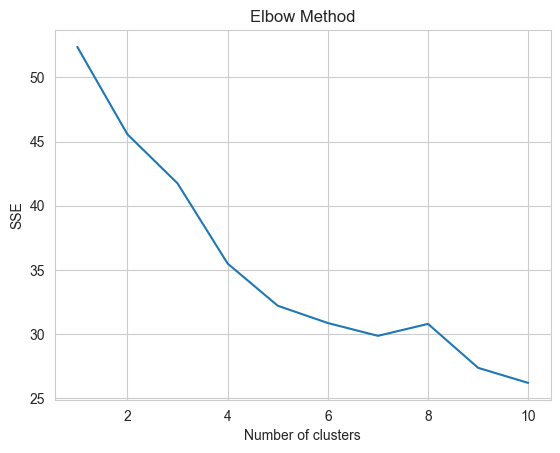

In [326]:
# Plotting (if dimensional reduction like PCA or t-SNE has been applied to reduce tfidf_matrix to 2D)
sns.set_style("whitegrid")
g = sns.lineplot(x=range(1, n), y=sse)

g.set(xlabel="Number of clusters", ylabel="SSE", title='Elbow Method')

plt.show()

Based on the graph above, using the elbow method, the optimal clusters are __6__.</br> I'll try to use clusters around this number to see what gives me the best result.

In [327]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import csr_matrix

def cluster_and_visualize(tfidf_matrix: csr_matrix, k: int):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"For {k} clusters, the average silhouette score is: {silhouette_avg}")
    
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())
    centroids = kmeans.cluster_centers_
    reduced_centroids = pca.transform(centroids)
    
    # Create a color map
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], 
                    color=color, label=f'Cluster {i}', alpha=1)

    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=150, c='black', label='Centroids')
    plt.title(f'2D PCA of {k} Claim Clusters with Centroids')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best')
    plt.show()



For 4 clusters, the average silhouette score is: 0.20201061760775252


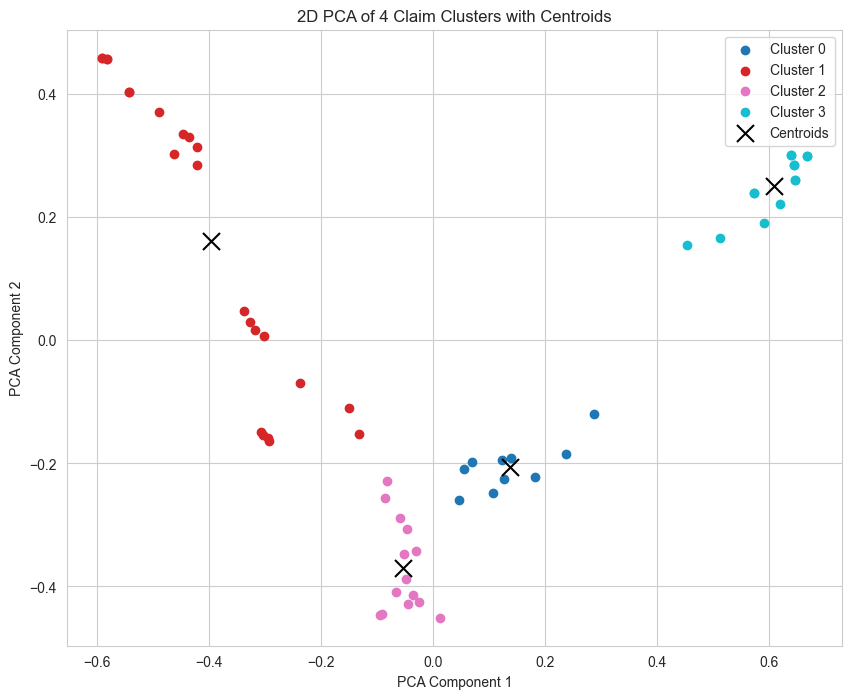

For 5 clusters, the average silhouette score is: 0.2244480287046338


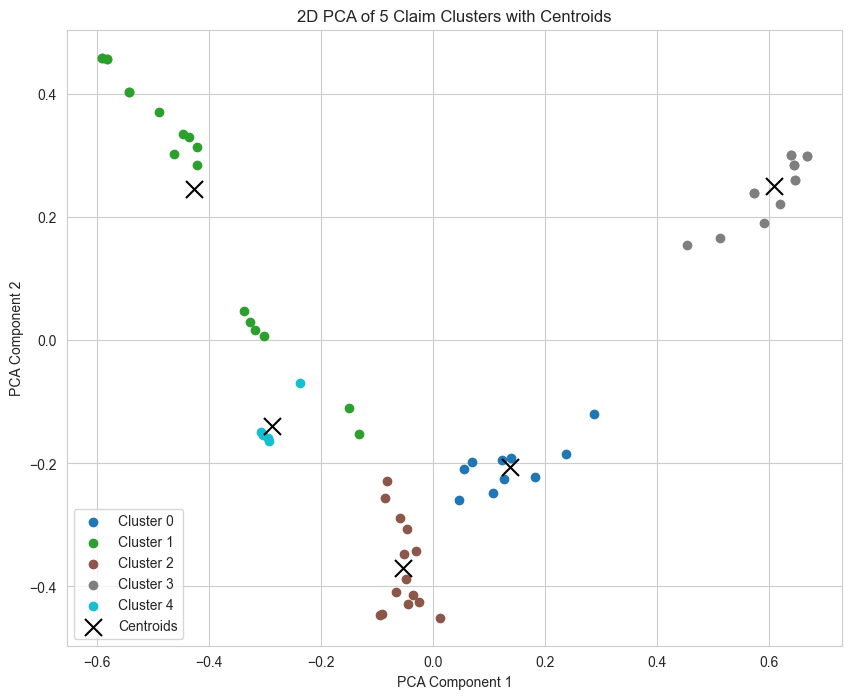

For 6 clusters, the average silhouette score is: 0.22490980905518235


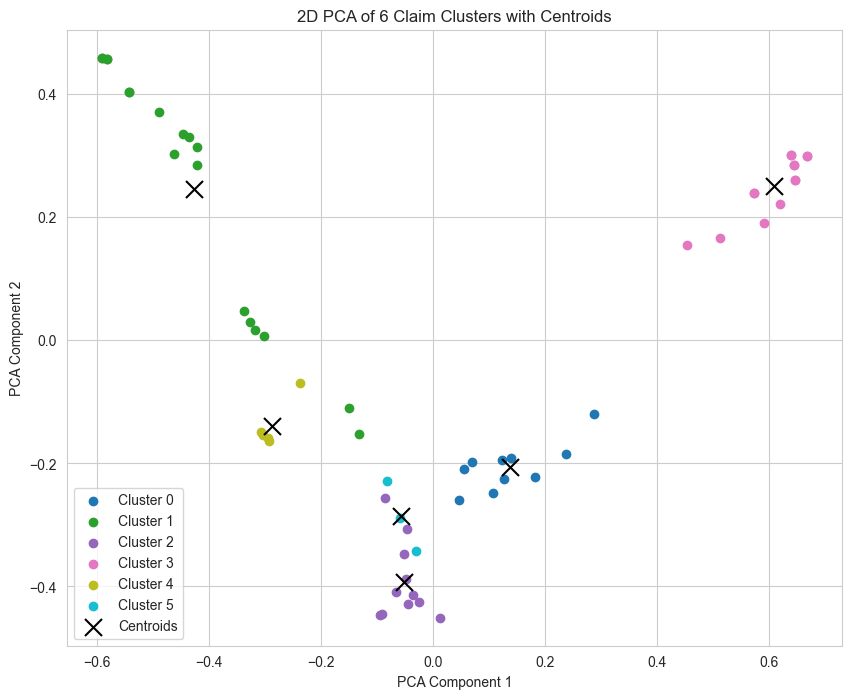

For 7 clusters, the average silhouette score is: 0.2140500588931559


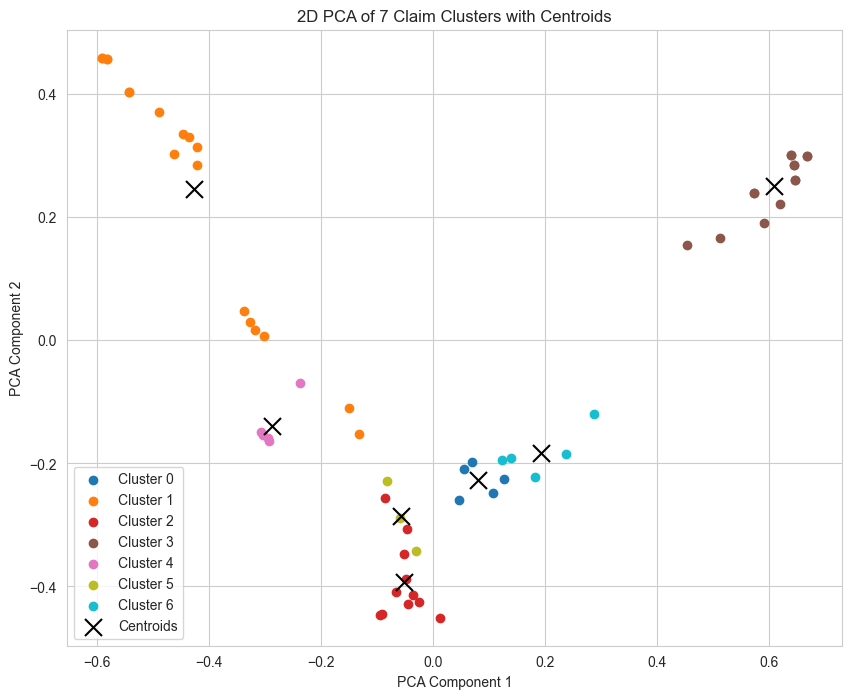

In [328]:
for i in range(4, 8):
    cluster_and_visualize(tfidf_matrix, k=i)

Based on these resulst, I'll use `k = 4`:</br>
1. The groups distribution is better</br>
2. The silhouette score is not so different from `k = 5, 6`

In [329]:
# Apply K-Means with K=4
k=4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# Load original data to attach labels
df = pd.read_csv('processed_patent_claims.csv')
df['Cluster Label'] = cluster_labels

# Save the DataFrame with cluster labels for further analysis
df.to_csv('claims_with_clusters.csv', index=False)

Extracting Keywords for Each Cluster:

In [330]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your vectorizer to access feature names
vectorizer = TfidfVectorizer(max_features=500)
vectorizer.fit_transform(df['Normalized Claim'])

# Get the centroids of the clusters
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# Display the top terms per cluster
for i in range(k):
    print(f"Cluster {i} top words:")
    top_words = [terms[ind] for ind in order_centroids[i, :15]]
    print(", ".join(top_words))



Cluster 0 top words:
said, according, source, method, indication, internal, gateway, claim, medium, wherein, received, message, gcp, external, connected
Cluster 1 top words:
output, signal, stimulus, domain, waveform, microphone, time, system, wave, sine, representing, voltage, defined, comprises, wherein
Cluster 2 top words:
apparatus, first, call, second, button, mean, predetermined, claim, one, mode, transfer, comprising, display, information, switch
Cluster 3 top words:
predefined, threshold, loss, jitter, packet, said, measured, call, indication, backbone, associated, mean, configured, processing, setup


### Clusters Analysis
* __Cluster 0__: Focused on methods according to claims involving sources and indications. This cluster seems to be dealing with methodological steps in technology, perhaps related to processes or operations specified in patents.</br></br>
* __Cluster 1__: Concerns output signals, stimulus, and waveform. This might relate to electronics or communication systems where signal processing is essential.</br></br>
* __Cluster 2__: Revolves around apparatuses, possibly dealing with hardware components or devices that have specific functionalities like calls.</br></br>
* __Cluster 3__: Dominated by terms associated with predefined thresholds, loss, and jitter, suggesting a focus on performance parameters or thresholds in network systems or communications.

### 2.2 Hierarchical Clustering

In [331]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import load_npz

In [332]:
# Load the TF-IDF matrix
tfidf_matrix = load_npz('tfidf_matrix.npz')

# Generate the linkage matrix using Ward's method
Z = linkage(tfidf_matrix.toarray(), method='ward')

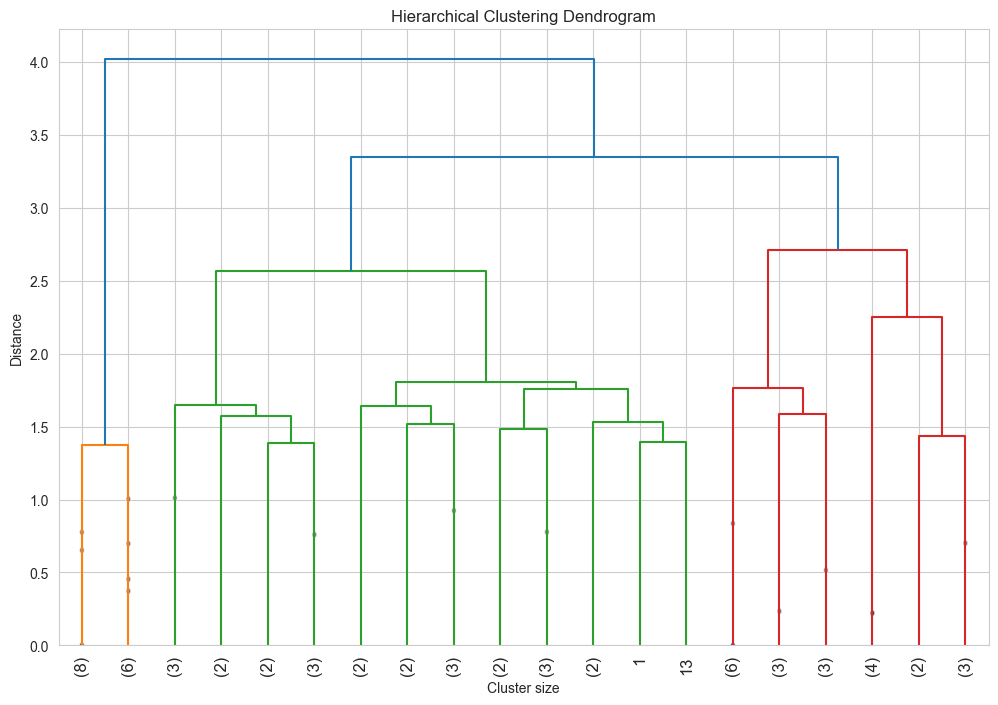

In [333]:
# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last 12 merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True  # to get a feel for the distribution inside the larger clusters
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

### 2.3 GPT for Feature Extraction